This requires you to write a 2D GAN game. I let you to get into the topic yourself, whitout any explonations from my side. You can watch lecture, seminar, read papers and tutorials (fun, fun, fun).

### Homework

I want you to implement a simple 2D GAN game. The kind of animation, I want to see is like in [this video](https://www.youtube.com/watch?v=KeJINHjyzOU) at 15:30 or in [here](https://habrahabr.ru/post/275429/) but in 2D. You can google, search code at github, whatever, but the network should be based on Theano. 

Basically you will need to come up with true distribution $P$, say mixture of gaussians (surprise me), sample some data from it. Visualize it as a heatmap. To visualize $G$ density you can fix $N$ noise vectors $\{z_i\} \quad i=1,\dots, N$ and draw a circle for each $G(z_i)$. It is also funny to visualize discriminator as a vector field (can be done with `plt.arrow`). Look how it should be in the middle of [this page](http://www.inference.vc/an-alternative-update-rule-for-generative-adversarial-networks/).

Please, make sure your code works if 'Run All' is pressed and it draws some animation.

Good luck!

In [2]:
import theano
import theano.tensor as T
from lasagne.nonlinearities import rectify, sigmoid, linear, tanh
import lasagne
import numpy as np
import scipy.stats as st

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.mlab as mlab
%matplotlib inline
import matplotlib.animation

from IPython import display

/home/necnec/progs/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [20]:
G_input = T.matrix('Gx')
G_l1 = lasagne.layers.InputLayer((None, 2), G_input)
G_l2 = lasagne.layers.DenseLayer(G_l1, 10, nonlinearity=rectify)
G_l3 = lasagne.layers.DenseLayer(G_l2, 10, nonlinearity=rectify)
G_l4 = lasagne.layers.DenseLayer(G_l3, 2, nonlinearity=linear)
G = G_l4

G_out = lasagne.layers.get_output(G)

# discriminators
D1_input = T.matrix('D1x')
D1_l1 = lasagne.layers.InputLayer((None, 2), D1_input)
D1_l2 = lasagne.layers.DenseLayer(D1_l1, 100, nonlinearity=tanh)
D1_l3 = lasagne.layers.DenseLayer(D1_l2, 100, nonlinearity=tanh)
D1_l4 = lasagne.layers.DenseLayer(D1_l3, 1, nonlinearity=sigmoid)
D1 = D1_l4

D2_l1 = lasagne.layers.InputLayer((None, 2), G_out)
D2_l2 = lasagne.layers.DenseLayer(D2_l1, 100, nonlinearity=tanh, W=D1_l2.W, b=D1_l2.b)
D2_l3 = lasagne.layers.DenseLayer(D2_l2, 100, nonlinearity=tanh, W=D1_l3.W, b=D1_l3.b)
D2_l4 = lasagne.layers.DenseLayer(D2_l3, 1, nonlinearity=sigmoid, W=D1_l4.W, b=D1_l4.b)
D2 = D2_l4

D1_out = lasagne.layers.get_output(D1)
D2_out = lasagne.layers.get_output(D2)

In [21]:
# objectives
G_obj = (T.log(1 - D2_out)).mean()
D_obj = (T.log(D1_out) + T.log(1 - D2_out)).mean()

# parameters update and training
G_params = lasagne.layers.get_all_params(G, trainable=True)
G_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
G_updates = lasagne.updates.nesterov_momentum(G_obj, G_params, learning_rate=G_lr, momentum=0.6)
G_train = theano.function([G_input], G_obj, updates=G_updates)

D_params = lasagne.layers.get_all_params(D1, trainable=True)
D_lr = theano.shared(np.array(0.1, dtype=theano.config.floatX))
D_updates = lasagne.updates.nesterov_momentum(-D_obj, D_params, learning_rate=D_lr, momentum=0.6)
D_train = theano.function([G_input, D1_input], D_obj, updates=D_updates)

Generate = theano.function([G_input],G_out)
CalcD = theano.function([D1_input], D1_out.mean())
CalcG = theano.function([G_input], D2_out.mean())

In [22]:
mu1 = [1,5]
sig1 = [[2,0.5], [0.5,11]]
mu2 = [-2,-2]
sig2 = [[8,2.5], [2.5,5]]
p = 0.46
def genTrueProb(x):
    return p * st.multivariate_normal.pdf(x, mu1, sig1) + (1.-p) * st.multivariate_normal.pdf(x, mu2, sig2)

def genTrueValues(N):
    i = np.random.binomial(1, p)
    return i * np.random.multivariate_normal(mu1, sig1, N) \
        + (1-i) * np.random.multivariate_normal(mu2, sig2, N)

def genNoise(N):
    return np.vstack((np.random.uniform(-10.0, 10.0, N), np.random.uniform(-10.0, 10.0, N))).T

In [23]:
X = np.mgrid[-10:10:.05, -10:10:.05]
shape_ = X.shape
probs = genTrueProb(X.reshape(2,-1).T).reshape(shape_[1],shape_[2])

def visualize(z_gen, z_gen_prev):
    plt.clf()
    plt.contourf(X[0], X[1], probs, 15, cmap=plt.cm.YlGn)
    plt.scatter(z_gen_prev[:,0],z_gen_prev[:,1])
    for i in range(len(z_gen)):
        plt.arrow(z_gen_prev[i,0], 
                  z_gen_prev[i,1],
                  z_gen[i,0]-z_gen_prev[i,0],
                  z_gen[i,1]-z_gen_prev[i,1], 
                  fc="k", 
                  ec="k")
    display.clear_output(wait=True)
    display.display(plt.gcf())

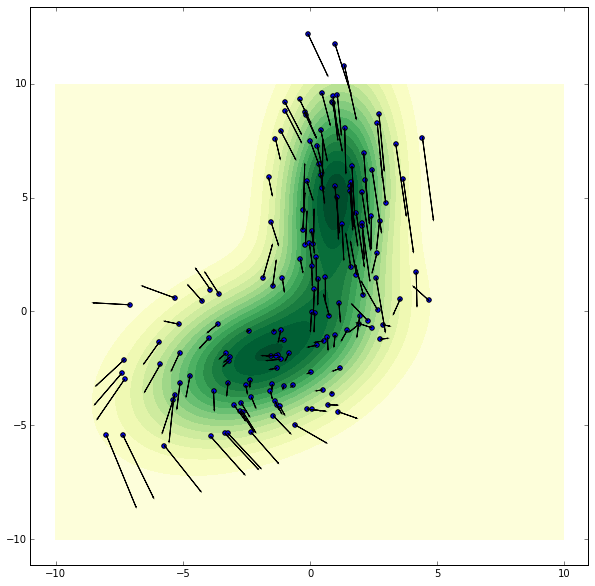

Elemwise{mul,no_inplace}.0 Elemwise{mul,no_inplace}.0


In [24]:
# training loop

epochs = 5000
k = 50
M = 100  # mini-batch size

z_test = genNoise(150)
z_gen_prev = Generate(z_test)
plt.figure(figsize=(10,10))

val_test_size=10000
g_vals = []
d_vals = []
for i in range(epochs):
    if i % 50 == 0:
        print "Epoch #{0}".format(i)
    for j in range(k):
        x = genTrueValues(M)  # sampled orginal batch
        z = genNoise(M)
        D_train(z.reshape(M, 2), x.reshape(M, 2))
    z = genNoise(M)
    G_train(z.reshape(M, 2))
    if i % 10 == 0:  # lr decay
        G_lr *= 0.999
        D_lr *= 0.999
        
    if i % 150 == 0:
        x = genTrueValues(val_test_size)  # sampled orginal batch
        z = genNoise(val_test_size)
        g_vals.append(CalcG(z.reshape(val_test_size, 2)))
        d_vals.append(CalcD(x.reshape(val_test_size, 2)))
        z_gen = Generate(z_test)
        visualize(z_gen, z_gen_prev)
        z_gen_prev = z_gen
        plt.savefig('fig/'+str(i))
plt.clf()
print G_lr,D_lr

In [26]:
!ls fig/*.png | sort -V | xargs -I {} echo "file '{}'" > list.txt
!ffmpeg -r 2 -f concat -i list.txt  out.mp4
!ffmpeg -i 'out.mp4' 'out.gif'

ffmpeg version N-79139-gde1a0d4 Copyright (c) 2000-2016 the FFmpeg developers
  built with gcc 4.8 (Ubuntu 4.8.4-2ubuntu1~14.04.1)
  configuration: --extra-libs=-ldl --prefix=/opt/ffmpeg --mandir=/usr/share/man --enable-avresample --disable-debug --enable-nonfree --enable-gpl --enable-version3 --enable-libopencore-amrnb --enable-libopencore-amrwb --disable-decoder=amrnb --disable-decoder=amrwb --enable-libpulse --enable-libfreetype --enable-gnutls --enable-libx264 --enable-libx265 --enable-libfdk-aac --enable-libvorbis --enable-libmp3lame --enable-libopus --enable-libvpx --enable-libspeex --enable-libass --enable-avisynth --enable-libsoxr --enable-libxvid --enable-libvidstab
  libavutil      55. 19.100 / 55. 19.100
  libavcodec     57. 30.100 / 57. 30.100
  libavformat    57. 29.101 / 57. 29.101
  libavdevice    57.  0.101 / 57.  0.101
  libavfilter     6. 40.102 /  6. 40.102
  libavresample   3.  0.  0 /  3.  0.  0
  libswscale      4.  0.100 /  4.  0.100
  libswresample   2.  0.101 /

Ниже представлен график - среднее значение дескриптора на примерах (10к) из истинного распределения и сгенерированного.
В идеале обе линии должны стремиться к 1, однако видим, что дескриминатор недообучился, А генератор повторяя кривую для истины, напротив подстроился под распределение  

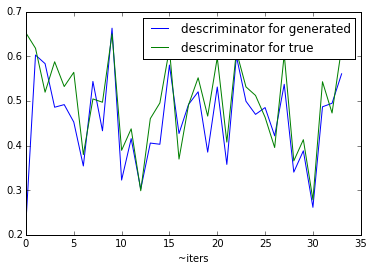

In [25]:
plt.plot(range(len(g_vals)),g_vals, label='descriminator for generated')
plt.plot(range(len(d_vals)),d_vals, label='descriminator for true')
plt.xlabel('train epochs')
plt.xlabel('~iters')
plt.legend()